# Main Computation File

This file actually solves the household life cycle problem (provides the optimal policies) by using parameters and shock processes given by other two files (Model-1Parameter, Model-2Shocks)



In [1]:
#0. Libraries Setup
#1) Importing Data
import os
from scipy.io import loadmat #Importing Matlab data

#2) Dataset Manipulation
import pandas as pd

#3) Mathematical/Statistical computation
import numpy as np
import numpy.ma as ma #Correlation while ignoring the missing data
import statistics as stat

#4) Plotting
import matplotlib
import matplotlib.pyplot as plt
# -> cf) magic function for IPython and Jupyter Notebook to show the graph well
# -> cf) In original Python, % means remainder from the division so below will not work
# -> cf) %matplotlib inline 
import matplotlib.dates as mdates #Date Library
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

#5) Regressions 
import statsmodels.formula.api as sm # Regression with Formula
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from linearmodels.iv import results
from linearmodels.compat.statsmodels import Summary
from linearmodels.compat.statsmodels import summary
from linearmodels.iv import compare
#from linearmodels.datasets import mroz #Why Do We Need?
#from linearmodels import PanelOLS #Maybe we do not need
import statsmodels.formula.api as smf #For Newey-West Covariance Matrix

#6) Regression Results to Tex Output
from statsmodels.iolib.summary2 import summary_col # Regression Output Table
#import tabulate
#from tabulate import tabulate
#print(tabulate([['Alice', 24], ['Bob', 19]], headers=['Name', 'Age'], tablefmt='orgtbl'))

#7) Math
import math

#8) Random Number Generator
import random

#9) f-SOLVER
import scipy
from scipy import stats
from scipy.stats import lognorm
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy import interpolate

#10) numba
from numba import jit, jitclass, njit, prange, int64, float64
import numpy
import math
import time
from scipy.stats import norm
from collections import OrderedDict
import sys

#11) Function partial changes
import functools

#12) 3d plot
from mpl_toolkits import mplot3d

## 1. Importing Parameters and Shock Processes

In [2]:
#1.1. Read parameters for the shocks form parameter file.
os.chdir(r'C:\Users\Owner\Dropbox\8. Python Space\Research1-HousingPortfolioJeonseData\Paramter')
parameterset=pd.read_csv('parameter.csv')  
FullshockFinal=pd.read_csv('FullShockFinal1.csv')  
lambdaPS=pd.read_csv('survivalprob.csv')
LIncomeGrowthProcess=pd.read_csv('LIncomeGrowthProcess.csv')

In [3]:
#1.2. Assign Parameters

#1.2.1. Household Problem Parameters
omega=parameterset['Parameter'][0] #housing versus non-durable consumption
rho=parameterset['Parameter'][1] #inverse of the elasticity of intertemporal substitution 
gamma=parameterset['Parameter'][2] #CRRA risk aversion
beta=parameterset['Parameter'][3] #discount factor
xi=parameterset['Parameter'][4] #probability of moving - Vestman 2019 different for each age
alpha_f=parameterset['Parameter'][5] #bequest strength (annuity factor)
beta_b=parameterset['Parameter'][6] #bequest strength (discount factor)
T_b=parameterset['Parameter'][7] #bequest strength (time period)
lambda_r=parameterset['Parameter'][8] #ratio of retirement income to the last working age income
R_f=parameterset['Parameter'][9] #risk free rate
mu_r=parameterset['Parameter'][10] #risk premium 
mu_h=parameterset['Parameter'][11] #expected growth of house price
tau_r=parameterset['Parameter'][12] #ratio of yearly rent to house price
Jbar=parameterset['Parameter'][13] #ratio of Jeonse deposit to house price -> Refer to the R.file
delta_J=parameterset['Parameter'][14] #downpayment ratio for Jeonse
phi_J=parameterset['Parameter'][15] #Jeonse contract cost 
chi=parameterset['Parameter'][16] #maintenance fee
delta=parameterset['Parameter'][17] #downpayment ratio for home purchase
phi_b=parameterset['Parameter'][18] #House purchase cost
phi=parameterset['Parameter'][19] #selling cost
Hbar=parameterset['Parameter'][20] #minimum house value (lower than it, rent or jeonse)
delta_v=parameterset['Parameter'][21] #standard deviation of idiosyncratic labor income shock
delta_ep=parameterset['Parameter'][22] #standard deviation of idiosyncratic stock market return
delta_n=parameterset['Parameter'][23] #standard deviation of housing return
corrHS=parameterset['Parameter'][24] # correlation between housing return and stock return correlation
eta_en=parameterset['Parameter'][25] # coefficient in front of stock return shock so that it goes into housing return equation for correlation.
corrYS=parameterset['Parameter'][26] # correlation between labor income and stock return
corrHY=parameterset['Parameter'][27] # correlation between housing return and labor income
eta_nn=parameterset['Parameter'][28] # coefficient for shock correlated to housing return and exist in labor income shock part
eta_eo=parameterset['Parameter'][29] # coefficient for shock correlated to stock return and exist in labor income shock part
LT=parameterset['Parameter'][30] #Longevity 20 - 80
b_b=parameterset['Parameter'][31] #bequest constant multiplier
Lage=int(parameterset['Parameter'][32]) #bequest constant multiplier
DTI_J=parameterset['Parameter'][33]
DTI_H=parameterset['Parameter'][34]

#1.2.2. Life Cycle Parameters
LIncomeGrowthProcess=np.array(LIncomeGrowthProcess['0']) #deterministic labor income growth profile
lambdaPS=np.array(lambdaPS['0']) #survival probability conditional on age
#lambdaPS=np.array(lambdaPS)

#1.2.3. Shock Processes (i.i.d) in my case
FullshockFinal=pd.DataFrame(FullshockFinal) #Possible shock realization and probability 
LaborIncomeShock=np.array(FullshockFinal.YgridV+FullshockFinal.SgridV_Y+FullshockFinal.HgridV_Y, dtype=float)
HousePriceShock=np.array(FullshockFinal.HgridV+FullshockFinal.SgridV_H, dtype=float)
StockReturnShock=np.array(FullshockFinal.SgridV, dtype=float)
Probability=np.array(FullshockFinal.Prob, dtype=float)

## 2. Set up the Grid for State Space

Important Point

1) Grid Maximum for y
- Since X contains Y, Y/X cannot be larger than 1

2) Grid Maximum for h
- Due to budget constraint, PH/X cannot be larger than the inverse of [tau_r, (delta_J+phi_J)*Jbar, chi+delta+phi_b, (chi+delta-phi)] for renter, Jeonse renter, and buyer. 
- This will be accounted in the budget constraint of the proble later

3) It is almost impossible for stayer to have value of 'h' larger than chi+delta+phi_b by budget constraint (no choice above this by purchaser)
- np.array([tau_r, (delta_J+phi_J)*Jbar, chi+delta+phi_b, (chi+delta-phi)])**(-1)
- Especially for stayer, it cannot be larger than (chi+delta-phi)**(-1)

In [4]:
#2. Setting up the grid for (x(=y),h) 

#2.1. Grid for x (cash-in-hand/wage) - it corresponds to x_t in the paper (inverse of x)
nx            = int(15);
xmin          = 1; #cannot be smaller than this, (X_t contains Y_t)
xmax          = 10.0;

#Function to construct the grid for cash-in-hand/laborincome (x)
xgrid = numpy.zeros(nx);
xstep = (xmax - xmin) /(nx - 1);
it = 0;
for i in range(0,nx):
    xgrid[i] = xmin + it*xstep;
    it = it+1;

#Setting up the grid for (y,h) (Inverse for later use)
#ny            = int(15);
#ymax          = 1;
#ymin          = 0;
#
#ygrid = numpy.zeros(ny);
#ystep = (ymax - ymin) /(ny - 1);
#it = 0;
#for i in range(0,ny):
#    ygrid[i] = ymin + it*ystep;
#    it = it+1;

#xgrid is the grid for inverse of y_t 
ny=nx
ygrid=xgrid**(-1)

#2.2. Grid for h (House-value / cash-in-hand) - This is important for stayer
nh            = int(10);
hmin          = 0;
hmax          = ((chi+delta-phi)**(-1)); #Budget constraint-wise/If h is larger than this, no solution for stayer's problem

# Function to construct the grid for housevalue/cash-in-hand (h)
hgrid = np.zeros(nh);
hstep = (hmax - hmin) /(nh - 1);
it = 0;
for i in range(0,nh):
    hgrid[i] = hmin + it*hstep;
    it = it+1;

# Print out the grids!
print(xgrid)
print(ygrid)
print(hgrid)

[ 1.          1.64285714  2.28571429  2.92857143  3.57142857  4.21428571
  4.85714286  5.5         6.14285714  6.78571429  7.42857143  8.07142857
  8.71428571  9.35714286 10.        ]
[1.         0.60869565 0.4375     0.34146341 0.28       0.23728814
 0.20588235 0.18181818 0.1627907  0.14736842 0.13461538 0.12389381
 0.1147541  0.10687023 0.1       ]
[0.         0.18737118 0.37474236 0.56211355 0.74948473 0.93685591
 1.12422709 1.31159828 1.49896946 1.68634064]


## 3. Setting up Value Functions and Policy Functions - To save the values

In [13]:
####################################################################################################################
####################  #######################
####################################################################################################################

In [5]:
#To make it integer
LT=int(LT) #age

#3.1. Initialize value function V
V_r     = numpy.zeros((LT+1, nx)) #age = LT+1 means "death", zero utility
V_j     = numpy.zeros((LT+1, nx))
V_p     = numpy.zeros((LT+1, nx))
V_nonow = numpy.zeros((LT+1, nx))
V_s     = numpy.zeros((LT+1, nx, nh))
V_ow    = numpy.zeros((LT+1, nx, nh))

#3.2. Optimal Policy for c,h,a,alpha - renter - one state variable
c_r      = numpy.zeros((LT+1, nx))
h_r      = numpy.zeros((LT+1, nx))
a_r      = numpy.zeros((LT+1, nx))
alpha_r  = numpy.zeros((LT+1, nx))

#3.3. Optimal Policy for c,h,a,alpha - jeonse - one state variable
c_j      = numpy.zeros((LT+1, nx))
h_j      = numpy.zeros((LT+1, nx))
a_j      = numpy.zeros((LT+1, nx))
alpha_j  = numpy.zeros((LT+1, nx))

#3.4. Optimal Policy for c,h,a,alpha - purchaser - two state variables
c_p      = numpy.zeros((LT+1, nx))
h_p      = numpy.zeros((LT+1, nx))
a_p      = numpy.zeros((LT+1, nx))
alpha_p  = numpy.zeros((LT+1, nx))

#3.5. Optimal Policy for Housing Tenure - Nonowner - one state variable
ht_nonow = numpy.zeros((LT, nx))

#3.6. Optimal Policy for c,h,a,alpha - stayer - two state variables
c_s      = numpy.zeros((LT+1, nx, nh))
h_s      = numpy.zeros((LT+1, nx, nh)) #Will be same with given h value
a_s      = numpy.zeros((LT+1, nx, nh))
alpha_s  = numpy.zeros((LT+1, nx, nh))

#3.7. Optimal Policy for Housing Tenure - Owner - two state variables
ht_ow    = numpy.zeros((LT, nx, nh))

## 4. Defining the class for state vectors

In [15]:
#4.1. Comming up with class for state vectors (state vars + parameters + shocks)
specs = OrderedDict()
#the number of states
specs['ind'] = int64 #possible total states cases (x,h)
specs['nx'] = int64 #possible cases for x
specs['ny'] = int64 #possible cases for y
specs['nh'] = int64 #possible cases for h
specs['LT'] = int64 #longevity 20+LT - maximum age in model
specs['age'] = int64 #current age
specs['cx'] = float64 #current x state
specs['cy'] = float64 #current y state
specs['ch'] = float64 #curren h state
#Shocks structure
specs['Probability'] = float64[:] #probability for each shock case
specs['LaborIncomeShock'] = float64[:] #labor income shock value for each shock case
specs['HousePriceShock'] = float64[:] #house price shock value for each shock case
specs['StockReturnShock'] = float64[:] #stock return shock value for each shock case
specs['xgrid'] = float64[:]
specs['ygrid'] = float64[:]
specs['hgrid'] = float64[:]
#household problem parameters
specs['omega']    = float64 #housing versus non-durable consumption    
specs['rho']      = float64 #inverse of the elasticity of intertemporal substitution       
specs['gamma']    = float64 #CRRA risk aversion         
specs['beta']     = float64 #discount factor        
specs['xi']       = float64 #probability of moving - Vestman 2019 different for each age     
specs['alpha_f']  = float64 #bequest strength (annuity factor)         
specs['beta_b']   = float64 #bequest strength (discount factor)          
specs['T_b']      = int64   #bequest strength (time period)        
specs['lambda_r'] = float64 #ratio of retirement income to the last working age income          
specs['R_f']      = float64 #risk free rate      
specs['mu_r']     = float64 #risk premium        
specs['mu_h']     = float64 #expected growth of house price         
specs['tau_r']    = float64 #ratio of yearly rent to house price          
specs['Jbar']     = float64 #ratio of Jeonse deposit to house price -> Refer to the R.file       
specs['delta_J']  = float64 #downpayment ratio for Jeonse           
specs['phi_J']    = float64 #Jeonse contract cost         
specs['chi']      = float64 #maintenance fee         
specs['delta']    = float64 #downpayment ratio for home purchase              
specs['phi_b']    = float64 #House purchase cost
specs['phi']      = float64 #House selling cost
specs['Hbar']     = int64 #minimum house value (lower than it, rent)
specs['b_b']      = float64  #bequest constant multiplier
specs['Lage']     = float64  #bequest constant multiplier
#Life-cycle-profile
specs['LIncomeGrowthProcess'] = float64[:]
specs['lambdaPS'] = float64[:]
#valuefunctions
specs['V_r'] = float64[:,:] #age, labor income rateio
specs['V_j'] = float64[:,:] #age, labor income rateio
specs['V_p'] = float64[:,:] #age, labor income rateio
specs['V_nonow'] = float64[:,:] #age, labor income rateio
specs['V_s'] = float64[:,:,:] #age, labor income rateio, house value ratio
specs['V_ow'] = float64[:,:,:]  #age, labor income rateio, house value ratio

In [16]:
#4.2. Object(class) structure for state and exogenous variables
#@jitclass(specs) #help to solve the problem faster
class modelState(object):
    def __init__(self,nx,ny,nh,LT,
                 Probability,LaborIncomeShock,HousePriceShock,StockReturnShock,xgrid,ygrid,hgrid,
                 omega,rho,gamma,beta,xi,alpha_f,beta_b,T_b,lambda_r,R_f,mu_r,mu_h,tau_r,Jbar,delta_J,phi_J,chi,delta,phi_b,phi,Hbar,b_b,Lage,
                 LIncomeGrowthProcess,lambdaPS,
                 V_r,V_j,V_p,V_nonow,V_s,V_ow
                ):
        self.nx                    = nx
        self.ny                    = ny                   
        self.nh                    = nh                    
        self.LT                    = LT                       
        self.Probability           = Probability           
        self.LaborIncomeShock      = LaborIncomeShock       
        self.HousePriceShock       = HousePriceShock         
        self.StockReturnShock      = StockReturnShock
        self.xgrid                 = xgrid
        self.ygrid                 = ygrid                   
        self.hgrid                 = hgrid                         
        self.omega                 = omega                 
        self.rho                   = rho                   
        self.gamma                 = gamma                   
        self.beta                  = beta                    
        self.xi                    = xi                     
        self.alpha_f               = alpha_f                
        self.beta_b                = beta_b               
        self.T_b                   = T_b                   
        self.lambda_r              = lambda_r                  
        self.R_f                   = R_f                   
        self.mu_r                  = mu_r                     
        self.mu_h                  = mu_h                       
        self.tau_r                 = tau_r                     
        self.Jbar                  = Jbar                          
        self.delta_J               = delta_J                    
        self.phi_J                 = phi_J                  
        self.chi                   = chi                       
        self.delta                 = delta                     
        self.phi_b                 = phi_b                       
        self.phi                   = phi                         
        self.Hbar                  = Hbar                        
        self.b_b                   = b_b
        self.Lage                  = Lage
        self.LIncomeGrowthProcess  = LIncomeGrowthProcess              
        self.lambdaPS              = lambdaPS                        
        self.V_r                   = V_r                          
        self.V_j                   = V_j                            
        self.V_p                   = V_p                           
        self.V_nonow               = V_nonow                     
        self.V_s                   = V_s                          
        self.V_ow                  = V_ow                                       
        
#here by using self, we define the attribute and method (Calling the sub component)

## 5. Solving Value Function

About Algorithm Structure

1) For Last period

- All value functions have age dimension which is one-element larger than other objects (policy function, ...)
- This last period contains all zero, which means after the household dies, there is no utility
- Given this last period non-owner and owner value functions (=0), households at their last age can solve the problem.

2) For every age starting backward from LT-1 (right before you die),
- 0) for every state y, 
- 1. solve V_r and policy functions
- 2. solve V_j and policy functions
- 3. solve V_p and policy functions
- 4. solve V_nonow and policy functions for every state h 
- 5. solve V_s and policy functions
- 6. solve V_ow and policy functions
- 7. Then go back to the 1 again with one less age

## 5.1. Define state vectors to set up the value function

In [17]:
#5.1. State Vector
state=modelState(nx,ny,nh,LT,
         Probability,LaborIncomeShock,HousePriceShock,StockReturnShock,xgrid,ygrid,hgrid,
         omega,rho,gamma,beta,xi,alpha_f,beta_b,T_b,lambda_r,R_f,mu_r,mu_h,tau_r,Jbar,delta_J,phi_J,chi,delta,phi_b,phi,Hbar,b_b,Lage,
         LIncomeGrowthProcess,lambdaPS,
         V_r,V_j,V_p,V_nonow,V_s,V_ow)

## 5.2. Define value functions to solve
: Define the function only one time. Just Change age, states, next period vars! 

## 5.2.1. Renter Problem

In [18]:
#@njit()
def value_rent(array, age1, cx, Vnonow, states=state):
    
    #Choice variables
    c=array[0]
    h=array[1]
    a=array[2]
    alpha=array[3]
    
    #Calling state vars
    y=cx**(-1) #initial states
    age=age1
    
    #Calling parameters
    # - Grid
    xgrid=states.xgrid #For interpolation
    hgrid=states.hgrid #For interpolation
    # - Household-Parameters
    omega=states.omega # Housing Consumption CD douglas
    gamma=states.gamma # Risk Aversion
    b_b=states.b_b # Bequest Multiplier
    alpha_f=states.alpha_f # Bequest Strength
    lambda_r=states.lambda_r #Retirement Income Ratio
    # - Stock Return, Housing Return
    mu_h=states.mu_h # Mean Housing Return
    R_f=states.R_f # Risk Free Rate
    mu_r=states.mu_r # Risk Premium
    # - Labor Income Life cycle Profile
    LIncomeGrowthProcess=states.LIncomeGrowthProcess
    # - Exoenous Shocks
    Probability=states.Probability
    HousePriceShock=states.HousePriceShock
    LaborIncomeShock=states.LaborIncomeShock
    StockReturnShock=states.StockReturnShock
    # - Surviving probability
    lambdaPS=states.lambdaPS
    # - Value Function of non-owner
    V_nonow=Vnonow
            
    #Calculating value 
    
    #1) Calculate the law of motion as a fct of choice and future shocks - array with shock cases 
    
    #- Next Period Housing Return Law of Motion
    NPHPG=np.exp(mu_h+HousePriceShock) #Next House Price Growth (Gross Growth of Cash-in-hand)
    
    #- Next Period Gamma, Next Period y Law of Motion, depending on your age (retirement)
    if age<Lage: #before the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock)
        NPY=(y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock))/NPGM     
    elif age==Lage: #at the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+lambda_r*y*np.exp(LIncomeGrowthProcess[age]) #At 65 age, next period, your wage does not experience any shock or growth
        NPY=lambda_r*y/NPGM
    elif age==LT-1: #before you die
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f) #At 65 age, next period, your wage does not experience any shock or growth
        NPY=0.1 #anyway no use before you die (no future value function)
    else: #after the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age])
        NPY=y/NPGM
    
    NPX=NPY**(-1)
    
    #2) Expectation Part (Bequest and Future Value Function)
    expectation1=0
    expectation2=0
    for i in range(0,len(Probability)):
        expectation1=expectation1+Probability[i]*((NPGM[i])/(NPHPG[i]**omega))**(1-gamma)
        if age<LT-1: #Future Value Function only before the last period
            expectation2=expectation2+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*np.interp(NPX[i], xgrid, V_nonow[age+1]))**(1-gamma)
    
    #3) Instantaneous Function Part
    if age<LT-1: #Future Value Function only before the last period
        finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(lambdaPS[age])*((expectation2**(1/(1-gamma)))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
    else: #At the last period, there is no next period value function
        finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*(expectation1**(1/(1-gamma))))**(1-rho)))**(1/(1-rho))
    
    return finalvalue #to use minimizer later, we put (-) here

## 5.2.2. Jeonse Renter Problem

In [19]:
#@njit
def value_jeonse(array, age1, cx, Vnonow, states=state):

    #Choice variables
    c=array[0]
    h=array[1]
    a=array[2]
    alpha=array[3]
    
    #Calling state vars
    y=cx**(-1) #initial states
    age=age1

    #Calling parameters
    # - Grid
    xgrid=states.xgrid #For interpolation
    hgrid=states.hgrid #For interpolation
    # - Household-Parameters
    omega=states.omega # Housing Consumption CD douglas
    gamma=states.gamma # Risk Aversion
    b_b=states.b_b # Bequest Multiplier
    alpha_f=states.alpha_f # Bequest Strength
    lambda_r=states.lambda_r #Retirement Income Ratio
    # - Household-Parameters for Jeonse
    Jbar=states.Jbar # Jeonse Deposit Size
    delta_J=states.delta_J # Jeonse Downpayment Ratio
    phi_J=states.phi_J # Jeonse transaction cost
    phi=states.phi # selling cost
    # - Stock Return, Housing Return
    mu_h=states.mu_h # Mean Housing Return
    R_f=states.R_f # Risk Free Rate
    mu_r=states.mu_r # Risk Premium
    # - Labor Income Life cycle Profile
    LIncomeGrowthProcess=states.LIncomeGrowthProcess
    # - Exoenous Shocks
    Probability=states.Probability
    HousePriceShock=states.HousePriceShock
    LaborIncomeShock=states.LaborIncomeShock
    StockReturnShock=states.StockReturnShock
    # - Surviving probability
    lambdaPS=states.lambdaPS
    # - Value Function of non-owner
    V_nonow=Vnonow
    
    #Calculating value 
    
    #1) Calculate the law of motion as a fct of choice and future shocks - array with shock cases 
    
    #- Next Period Housing Return Law of Motion
    NPHPG=np.exp(mu_h+HousePriceShock) #Next House Price Growth (Gross Growth of Cash-in-hand) 
    
    #- Next Period Gamma, Next Period y Law of Motion, depending on your age (retirement)
    if age<Lage: #before the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock)+h*Jbar*(1-(1-delta_J)*R_f)
        NPY=(y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock))/NPGM     
    elif age==Lage:  #at the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+lambda_r*y*np.exp(LIncomeGrowthProcess[age])+h*Jbar*(1-(1-delta_J)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
        NPY=lambda_r*y/NPGM
    elif age==LT-1:  #at the LAST Period No Future labor Income
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+h*Jbar*(1-(1-delta_J)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
        NPY=0.1 #Anyway no use before you die (no future value function)
    else: #after the retirement 
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age])+h*Jbar*(1-(1-delta_J)*R_f)
        NPY=y/NPGM
    NPX=NPY**(-1)
    
    #2) Expectation Part (Bequest and Future Value Function)
    expectation1=0
    expectation2=0
    for i in range(0,len(Probability)):
        expectation1=expectation1+Probability[i]*((NPGM[i])/(NPHPG[i]**omega))**(1-gamma)
        if age<LT-1: #Future Value Function only before the last period
            expectation2=expectation2+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*np.interp(NPX[i], xgrid, V_nonow[age+1]))**(1-gamma)
    
    #3) Instantaneous Function Part
    if age<LT-1: #Future Value Function only before the last period
        finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(lambdaPS[age])*((expectation2**(1/(1-gamma)))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
    else: #At the last period, there is no next period value function
        finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*(expectation1**(1/(1-gamma))))**(1-rho)))**(1/(1-rho))
    
    return finalvalue #to use minimizer later, we put (-) here

## 5.2.3. Purchaser Problem

In [20]:
#@njit
def value_purchase(array, age1, cx, Vnonow, Vow, states=state):

    #Choice variables
    c=array[0]
    h=array[1]
    a=array[2]
    alpha=array[3]
    
    #Calling state vars
    y=cx**(-1) #initial states
    age=age1
    
    #Calling parameters
    # - Grid
    xgrid=states.xgrid #For interpolation
    hgrid=states.hgrid #For interpolation
    # - Household-Parameters
    omega=states.omega # Housing Consumption CD douglas
    gamma=states.gamma # Risk Aversion
    b_b=states.b_b # Bequest Multiplier
    alpha_f=states.alpha_f # Bequest Strength
    lambda_r=states.lambda_r #Retirement Income Ratio
    # - Household-Parameters for Purchaser
    phi=states.phi
    delta=states.delta
    xi=states.xi    
    # - Stock Return, Housing Return
    mu_h=states.mu_h
    R_f=states.R_f
    mu_r=states.mu_r
    # - Labor Income Life cycle Profile
    LIncomeGrowthProcess=states.LIncomeGrowthProcess
    # - Exoenous Shocks
    Probability=states.Probability
    HousePriceShock=states.HousePriceShock
    LaborIncomeShock=states.LaborIncomeShock
    StockReturnShock=states.StockReturnShock
    # - Surviving probability
    lambdaPS=states.lambdaPS
    # - Value Function of non-owners and owners
    V_nonow=Vnonow
    V_ow=Vow # Until here
    
    #Calculating value 
    
    #1) Calculate the law of motion as a fct of choice and future shocks - array with shock cases 
    
    #- Next Period Housing Return Law of Motion
    NPHPG=np.exp(mu_h+HousePriceShock) 
    
    #- Next Period Gamma, Next Period y and h Law of Motion, depending on your age (retirement)            
    if age<Lage: #before the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock)+h*(NPHPG*(1-phi)-(1-delta)*R_f)
        hP=h*(NPHPG/NPGM)
        NPY=(y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock))/NPGM     
    elif age==Lage: #at the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+lambda_r*y*np.exp(LIncomeGrowthProcess[age])+h*(NPHPG*(1-phi)-(1-delta)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
        hP=h*(NPHPG/NPGM)
        NPY=lambda_r*y/NPGM
    elif age==LT-1: #at the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+h*(NPHPG*(1-phi)-(1-delta)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
        hP=h*(NPHPG/NPGM)
        NPY=0.1 #Anyway no use before you die (no future value function)
    else: #after the retirement 
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age])+h*(NPHPG*(1-phi)-(1-delta)*R_f)
        hP=h*(NPHPG/NPGM)
        NPY=y/NPGM
    
    NPX=NPY**(-1)
    
    #2) Expectation Part (Bequest and Future Value Function)
    expectation1=0 # bequest - no change
    expectation2=0 # next value function - moving shock
    expectation3=0 # next value function - no moving shock
    
    #3) Interpolate the future owner's value function
    V_ow2 = interpolate.interp2d(hgrid, xgrid, V_ow[age+1], kind='cubic', bounds_error=False) # - 2d interpolation, when # of grid increases, it become unavailable.
    
    for i in range(0,len(Probability)):
        expectation1=expectation1+Probability[i]*((NPGM[i])/(NPHPG[i]**omega))**(1-gamma)
        if age<LT-1:
            expectation2=expectation2+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*np.interp(NPX[i], xgrid, V_nonow[age+1]))**(1-gamma)
            expectation3=expectation3+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*V_ow2(hP[i],NPX[i]))**(1-gamma)
    
    #4) Instantaneous Function Part
    if age<LT-1: #Before the last period
        finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))
                     +beta*(lambdaPS[age])*xi*((expectation2**(1/(1-gamma)))**(1-rho))
                     +beta*(lambdaPS[age])*(1-xi)*((expectation3**(1/(1-gamma)))**(1-rho))
                     +beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
    else: #At the last period, there is no next period value function
        finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
    
    return finalvalue #to use minimizer later, we put (-) here

## 5.2.4. Stayer's Problem

In [21]:
#@njit
def value_stayer(array, age1, cx, ch, Vnonow, Vow, states=state): #be careful, we do not need h here!

    # Choice variable
    c=array[0]
    a=array[1]
    alpha=array[2]
    
    #Calling state vars
    y=cx**(-1) #initial states
    h=ch #initial states
    age=age1
    
    #Calling parameters
    # - Grid
    xgrid=states.xgrid
    hgrid=states.hgrid
    # - Household-Parameters
    omega=states.omega # Housing Consumption CD douglas
    gamma=states.gamma # Risk Aversion
    b_b=states.b_b # Bequest Multiplier
    alpha_f=states.alpha_f # Bequest Strength
    lambda_r=states.lambda_r #Retirement Income Ratio
    # - Household-Parameters for Stayer
    phi=states.phi
    delta=states.delta
    xi=states.xi
    # - Stock Return, Housing Return
    mu_h=states.mu_h
    R_f=states.R_f
    mu_r=states.mu_r
    # - Labor Income Life cycle Profile
    LIncomeGrowthProcess=states.LIncomeGrowthProcess
    # - Exoenous Shocks
    Probability=states.Probability
    HousePriceShock=states.HousePriceShock
    LaborIncomeShock=states.LaborIncomeShock
    StockReturnShock=states.StockReturnShock
    # - Surviving probability
    lambdaPS=states.lambdaPS
    # - Value Function of non-owners and owners
    V_nonow=Vnonow
    V_ow=Vow
    
    #Calculating value 
    
    #1) Calculate the law of motion as a fct of choice and future shocks - array with shock cases 
    
    #- Next Period Housing Return Law of Motion
    NPHPG=np.exp(mu_h+HousePriceShock) #Next House Price Growth
    
    #- Next Period Gamma, Next Period y and h Law of Motion, depending on your age (retirement)
    if age<Lage: #before the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock)+h*(NPHPG*(1-phi)-(1-delta)*R_f)
        hP=h*(NPHPG/NPGM)
        NPY=(y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock))/NPGM     
    elif age==Lage: #at the retirement
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+lambda_r*y*np.exp(LIncomeGrowthProcess[age])+h*(NPHPG*(1-phi)-(1-delta)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
        hP=h*(NPHPG/NPGM)
        NPY=lambda_r*y/NPGM
    elif age==LT-1:
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+h*(NPHPG*(1-phi)-(1-delta)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
        hP=h*(NPHPG/NPGM)
        NPY=0.1 #Anyway no use before you die (no future value function)        
    else: #after the retirement 
        NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age])+h*(NPHPG*(1-phi)-(1-delta)*R_f)
        hP=h*(NPHPG/NPGM)
        NPY=y/NPGM
    
    NPX=NPY**(-1)
    
    #2) Expectation Part (Bequest and Future Value Function)
    expectation1=0 # bequest - no change
    expectation2=0 # next value function - moving shock
    expectation3=0 # next value function - no moving shock
    
    #3) Interpolate the future owner's value function
    V_ow2 = interpolate.interp2d(hgrid, xgrid, V_ow[age+1], kind='cubic', bounds_error=False) # - 2d interpolation, when # of grid increases, it become unavailable..
    
    for i in range(0,len(Probability)):
        expectation1=expectation1+Probability[i]*((NPGM[i])/(NPHPG[i]**omega))**(1-gamma)
        if age<LT-1:
            expectation2=expectation2+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*np.interp(NPX[i], xgrid, V_nonow[age+1]))**(1-gamma)
            expectation3=expectation3+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*V_ow2(hP[i],NPX[i]))**(1-gamma)

    #4) Instantaneous Function Part
    if age<LT-1: #Before the last period
        finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))
                     +beta*(lambdaPS[age])*xi*((expectation2**(1/(1-gamma)))**(1-rho))
                     +beta*(lambdaPS[age])*(1-xi)*((expectation3**(1/(1-gamma)))**(1-rho))
                     +beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
    else: #At the last period, there is no next period value function
        finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
    
    return finalvalue #to use minimizer later, we put (-) here

## 5.3. Solve over states and ages - Actual Loop 

In [22]:
#@njit(parallel=True)
starttime = time.time()
for age in reversed(range(0,LT)): # For every age,
    start = time.time()
    #For Labor Income / Wealth state variable
    for i in range(0,nx):
        
        #1. Define state (x)
        x1=xgrid[i] # current state of labor income ratio
        y1=x1**(-1)
        #2. Calculating maximized value and policy function - Rent       

        #2.1. Define a Partial Function - I can set age and state
        value_rent1 = functools.partial(value_rent, age1=age, cx=x1, Vnonow=V_nonow)

        #2.2. boundray for values (no negative consumption, no borrowing, no short-selling)
        bounds = Bounds([0, 0, 0, 0], [1, tau_r**(-1), 1, 1])
        #2.3. budget constraint (Renter)
        linear_constraint = LinearConstraint([1, tau_r, 1, 0], [1], [1])
        #2.4. initial value 
        x0=np.array([0.4, 1, 0.55, 0.3])
        #2.5. Solve maximizer
        res = minimize(value_rent1, x0, method='SLSQP',
              constraints=[linear_constraint], bounds=bounds)        
        #2.6. Saving optimal policy function to array
        c_r[age,i]=res.x[0]
        h_r[age,i]=res.x[1]
        a_r[age,i]=res.x[2]
        alpha_r[age,i]=res.x[3]
        V_r[age,i]=-res.fun
        print('renter (done)'+str(i))

        #3. Calculating maximized value and policy function - Jeonse        
        
        #3.1. Define a Partial Function - I can set age and state
        value_jeonse1 = functools.partial(value_jeonse, age1=age, cx=x1, Vnonow=V_nonow)

        #3.2. boundray for values (no negative consumption, no borrowing, no short-selling)
        bounds = Bounds([0, 0, 0, 0], [1, ((delta_J+phi_J)*Jbar)**(-1), 1, 1])
        #3.3. budget constraint (Jeonse Renter) + DTI constraint
        linear_constraint = LinearConstraint([1, (delta_J+phi_J)*Jbar, 1, 0], 1, 1) 
        #linear_constraint = LinearConstraint([[1, (delta_J+phi_J)*Jbar, 1, 0],[0, (R_f-1)*(1-delta_J)*Jbar, 0, 0]], [0.99,0], [1, DTI_J*y1])     
        #3.4. initial value 
        x0=np.array([0.4, 1, 0.55, 0.3]) 
        #3.5. Solve maximizer        
        res = minimize(value_jeonse1, x0, method='SLSQP',
              constraints=[linear_constraint], bounds=bounds)
        #3.6. Saving optimal policy function to array
        c_j[age,i]=res.x[0]
        h_j[age,i]=res.x[1]
        a_j[age,i]=res.x[2]
        alpha_j[age,i]=res.x[3]
        V_j[age,i]=-res.fun
        print('Jeonse-renter (done)'+str(i))
        
        #4. Calculating maximized value and policy function - Purchaser

        #4.1. Define a Partial Function - I can set age and state
        value_purchase1 = functools.partial(value_purchase, age1=age, cx=x1, Vnonow=V_nonow, Vow=V_ow)
    
        #4.2. boundray for values (no negative consumption, no borrowing, no short-selling)        
        bounds = Bounds([0, 0, 0, 0], [1, (chi+delta-phi)**(-1), 1, 1]) #Housing value cannot be larger than this
        #4.3. budget constraint (Buyer) + DTI constraint 
        linear_constraint = LinearConstraint([1, (chi+delta+phi_b), 1, 0], 1, 1) 
        #linear_constraint = LinearConstraint([[1, (chi+delta+phi_b), 1, 0], [0, (R_f-1)*(1-delta), 0, 0]], [0.99,0], [1, DTI_H*y1]) # -  DTI included 
        #4.4. initial value 
        x0=np.array([0.4, 1, 0.55, 0.3])   
        #4.5. Solve maximizer
        res = minimize(value_purchase1, x0, method='SLSQP',
              constraints=[linear_constraint], bounds=bounds)

        #4.6. Saving optimal policy function to array
        c_p[age,i]=res.x[0]
        h_p[age,i]=res.x[1]
        a_p[age,i]=res.x[2]
        alpha_p[age,i]=res.x[3]
        V_p[age,i]=-res.fun    
        print('Buyer (done)'+str(i))

        #5. Non-Owner's problem
        V_nonow[age,i]=max([V_r[age,i],V_j[age,i],V_p[age,i]])
        ht_nonow[age,i]=np.argmax([V_r[age,i],V_j[age,i],V_p[age,i]])
        print('Non-owner (done)'+str(i))

        #Now State variable for h is also required
        for j in range(0,nh):
            
            #6. Define state (h)
            h1=hgrid[j] # current state of labor income ratio
            
            #7. Calculating maximized value and policy function - Stayer  

            #7.1. Define a Partial Function - I can set age and state
            value_stayer1 = functools.partial(value_stayer, age1=age, cx=x1, ch=h1, Vnonow=V_nonow, Vow=V_ow)          

            #7.2. boundray for values (no negative consumption, no borrowing, no short-selling)  
            bounds = Bounds([0, 0, 0], [1, 1, 1]) #stayer only has three arguments
            #7.3. budget constraint (Stayer)
            linear_constraint = LinearConstraint([1, 1, 0], [1-(chi+delta-phi)*h1], [1-(chi+delta-phi)*h1]) #budget constraint - given ch!
            #7.4. initial value 
            x0=np.array([(1-(chi+delta-phi)*h1)/2, (1-(chi+delta-phi)*h1)/2, 0.5]) #initial value contains three arguments!
            #7.5. Solve maximizer
            res = minimize(value_stayer1, x0, method='SLSQP',
                          constraints=[linear_constraint], bounds=bounds)

            #7.6. Saving optimal policy function to array
            c_s[age,i,j]=res.x[0]
            h_s[age,i,j]=h1
            a_s[age,i,j]=res.x[1]
            alpha_s[age,i,j]=res.x[2]
            V_s[age,i,j]=-res.fun
            print('Stayer (done)'+str(j))
            
            #8. Owner's Problem
            #Owner's problem
            V_ow[age,i,j]=max([V_nonow[age,i],V_s[age,i,j]])
            ht_ow[age,i,j]=np.argmax([V_nonow[age,i],V_s[age,i,j]])
            print('Owner (done)'+str(j))
            
    finish = time.time() - start
    print(str(age+1)+' age period finished')
    print(str(finish)+' second has been taken')
endtime = time.time()
print(str(starttime-endtime))

renter (done)0
Jeonse-renter (done)0
Buyer (done)0
Non-owner (done)0
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)1
Jeonse-renter (done)1
Buyer (done)1
Non-owner (done)1
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)2
Jeonse-renter (done)2
Buyer (done)2
Non-owner (done)2
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (do

Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)8
Jeonse-renter (done)8
Buyer (done)8
Non-owner (done)8
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)9
Jeonse-renter (done)9
Buyer (done)9
Non-owner (done)9
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)10
Jeonse-renter (done)10
Buyer (done)10
Non-owner (done)10
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer

renter (done)0
Jeonse-renter (done)0
Buyer (done)0
Non-owner (done)0
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)1
Jeonse-renter (done)1
Buyer (done)1
Non-owner (done)1
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)2
Jeonse-renter (done)2
Buyer (done)2
Non-owner (done)2
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (do

KeyboardInterrupt: 

## 6. Check whether solution worked well or not

I will check the concavity of the value functions and local (global) optima

## 6.1. First Point 
- ("Last period value function value for non-owner should be same across the y-states")
- It is natural that at the end you have a constant vector for the last period for any labor income state variable
- In our model, X_t already contains the current period labor income. Consequently, which labor income ratio I have does not matter. (Our true value function values are this code value function multiply CASH IN HAND X_t)

In [23]:
#1. Non-Owner(Renter, Jeonse Renter, Purchaser)s' Value Functions
print('last period value of non_owner is', V_nonow[LT-1])
print('last period value of renter is', V_r[LT-1])
print('last period value of jeonse renter is', V_j[LT-1])
print('last period value of purchaser is', V_p[LT-1]) 

last period value of non_owner is [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097]
last period value of renter is [3.373808 3.373808 3.373808 3.373808 3.373808 3.373808 3.373808 3.373808
 3.373808 3.373808 3.373808 3.373808 3.373808 3.373808 3.373808]
last period value of jeonse renter is [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097]
last period value of purchaser is [3.26738937 3.26738937 3.26738937 3.26738937 3.26738937 3.26738937
 3.26738937 3.26738937 3.26738937 3.26738937 3.26738937 3.26738937
 3.26738937 3.26738937 3.26738937]


In [26]:
#2. Owner(Stayer)'s Value Function
#For owner, it might be different depending on the state value h, because of selling cost and maintenance costs
print('last period value of owner is', V_ow[LT-1]) #it may be dominated by the non-owner's value
#Always we have different values for different housing states 
#- as housing value becomes larger, the volatility increases, transaction cost is high
print('last period value of stayer with 4 housing is', V_s[LT-1,1,4]) # check more later
print('last period value of stayer with 1 housing is', V_s[LT-1,1,1])
#- they are same even though they have different x_t, they are different only when they have different h_t

last period value of owner is [[3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097 3.406097
  3.406097 3.406097]
 [3.406097 3.406097 

## 6.2. Second Point 
- ("Did interpolation work well?")
- Sometimes, interpolation is done bad so may ruin the solutions 
- Check it by changing the "LT-1" value in the code from LT-1 to 0

In [ ]:
#6.0. 3-D result 
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

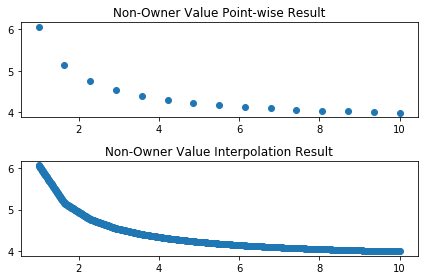

In [34]:
#6.2.1. Non-Owner's Problem
sample1=np.linspace(xmin, xmax, 1000)
Vresult=np.interp(sample1, xgrid, V_nonow[LT-2])

fig, axs = plt.subplots(2)
axs[0].plot(xgrid, V_nonow[LT-2], 'o')
axs[0].set_title('Non-Owner Value Point-wise Result')
axs[1].plot(sample1, Vresult, 'o')
axs[1].set_title('Non-Owner Value Interpolation Result')
fig.tight_layout()
plt.show()

In [370]:
#6.2. Owner's Value Function
#Owner's problem is maximum between non-owner's value and homeowner's value
#There are two types of concavity, first is like before lower x_t means more value

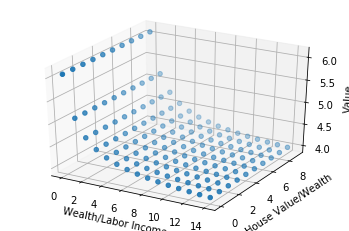

In [35]:
#6.2.1. Owner's Value Function (3d) - Point-wise
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line - component wise
xline = np.arange(ny)
yline = np.arange(nh)
x, y = np.meshgrid(xline, yline)
zline = V_ow[LT-2][x, y]
ax.scatter3D(x, y, zline, cmap='Greens');
ax.set_xlabel('Wealth/Labor Income')
ax.set_ylabel('House Value/Wealth')
ax.set_zlabel('Value');

#Here axis are the number for slot! not the value of laborincome/wealth

<IPython.core.display.Javascript object>


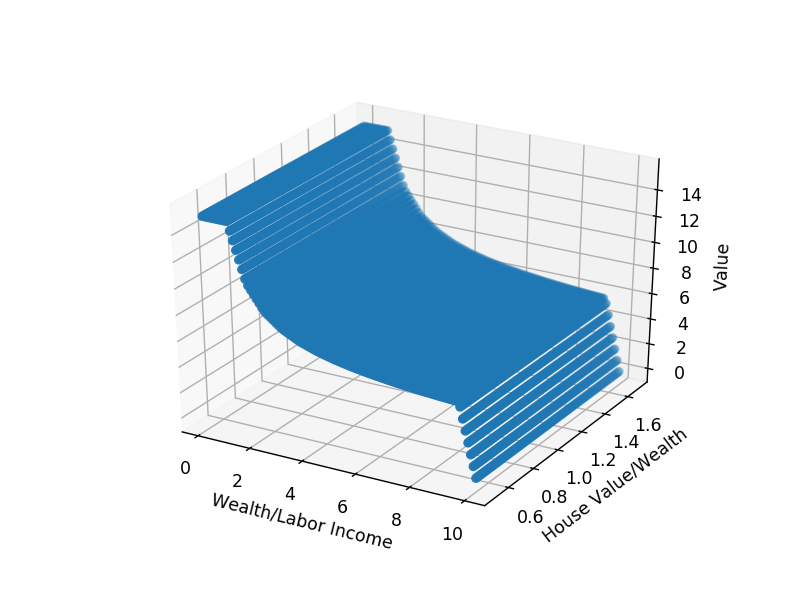

In [40]:
#6.2.2. Owner's Value Function (3d) - Interpolation result
V_ow2 = interpolate.interp2d(hgrid, xgrid, V_ow[LT-4], kind='linear', bounds_error=False)
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a 
xline = np.linspace(0.1, 10, 100)
yline = np.linspace(0.5, (chi+delta-phi)**(-1), 100)
Y, X = np.meshgrid(yline, xline)
zline = V_ow2(yline, xline)
ax.scatter3D(X, Y, zline, cmap='Greens');
ax.set_xlabel('Wealth/Labor Income')
ax.set_ylabel('House Value/Wealth')
ax.set_zlabel('Value');

<IPython.core.display.Javascript object>


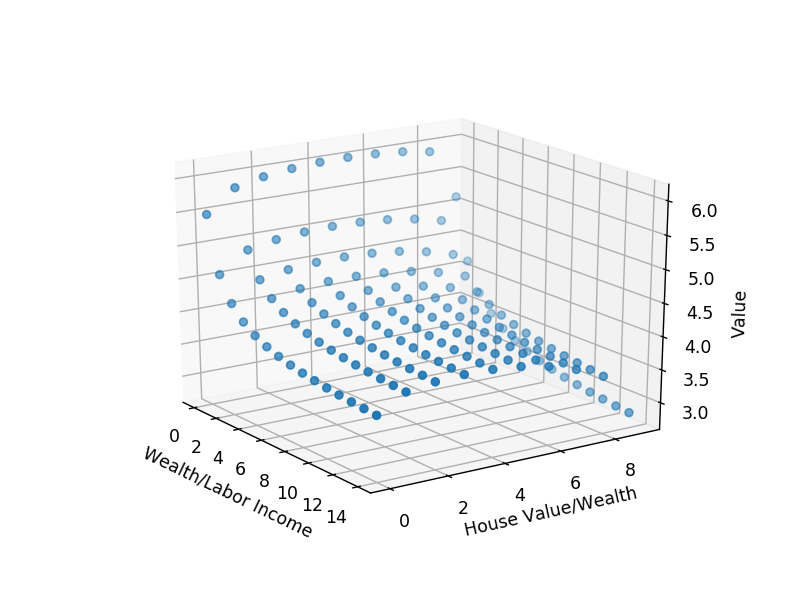

In [38]:
#6.2.3. Stayer's Value Function (3d) - Point-wise
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line - component wise
xline = np.arange(ny)
yline = np.arange(nh)
x, y = np.meshgrid(xline, yline)
zline = V_s[LT-2][x, y]
ax.scatter3D(x, y, zline, cmap='Greens');
ax.set_xlabel('Wealth/Labor Income')
ax.set_ylabel('House Value/Wealth')
ax.set_zlabel('Value');

#Here axis are the number for slot! not the value of laborincome/wealth
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.005)

<IPython.core.display.Javascript object>


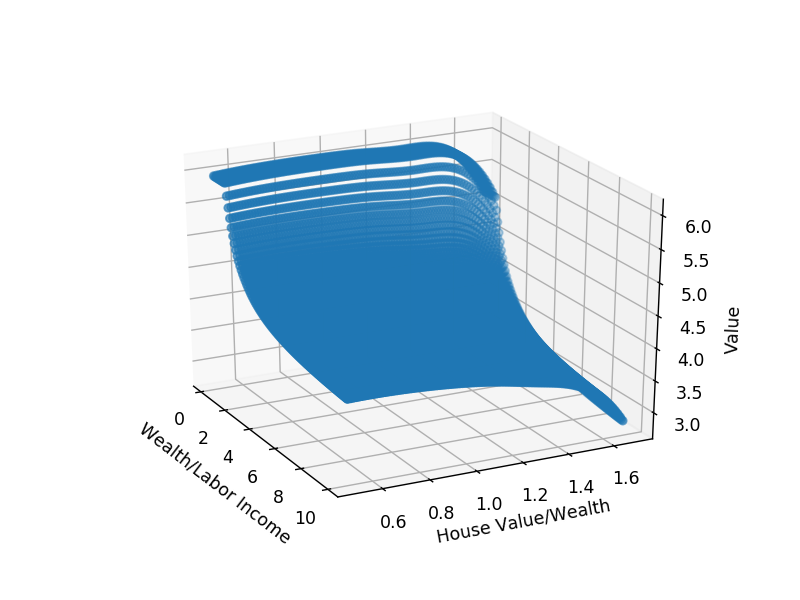

In [41]:
#6.2.4. Owner's Value Function (3d) - Interpolation result
V_s2 = interpolate.interp2d(hgrid, xgrid, V_s[LT-2], kind='cubic', bounds_error=False)
fig = plt.figure()
ax = plt.axes(projection='3d')

xline = np.linspace(0.1, 10, 100)
yline = np.linspace(0.5, (chi+delta-phi)**(-1), 100)
Y, X = np.meshgrid(yline, xline)
zline = V_s2(yline, xline)
ax.scatter3D(X, Y, zline, cmap='Greens');
ax.set_xlabel('Wealth/Labor Income')
ax.set_ylabel('House Value/Wealth')
ax.set_zlabel('Value');

#Here axis are the number for slot! not the value of laborincome/wealth
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.005)

In [ ]:
########## 여기부터 수정 11.11.

In [384]:
#5.2.6.1.3. Owner's Value Function (2d) - Second Source of Concavity (When staying is better)
#Especially for age 20, at 5th x grid (we see from owner's tenure choice that for some h_t staying is better, which can 
#generate the concavity caused by h_t)

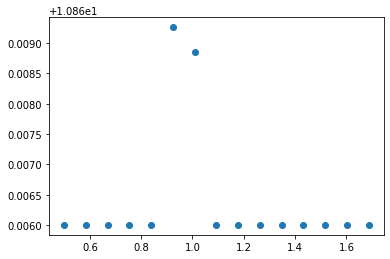

In [429]:
#5.2.6.1.3.1. Owner's Value Function (2d) - Second Source of Concavity (When staying is better) - Grid
plt.plot(hgrid,V_ow[4][5],'o')
ax.set_xlabel('House Value/Wealth')
ax.set_ylabel('Value')
plt.title('')
plt.show()

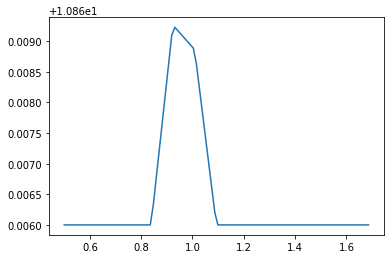

In [394]:
#5.2.6.1.3.2. Owner's Value Function (2d) - Second Source of Concavity (When staying is better) - Interpolation
V_ow2 = interpolate.interp2d(hgrid, xgrid, V_ow[4], kind='linear', bounds_error=False)
plt.plot(yline, V_ow2(yline,xgrid[5]))
ax.set_xlabel('House Value/Wealth')
ax.set_ylabel('Value')
plt.title('')
plt.show()

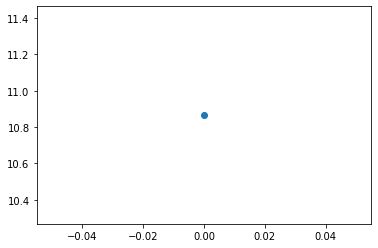

In [430]:
plt.plot(V_nonow[4][5],'o')

<IPython.core.display.Javascript object>


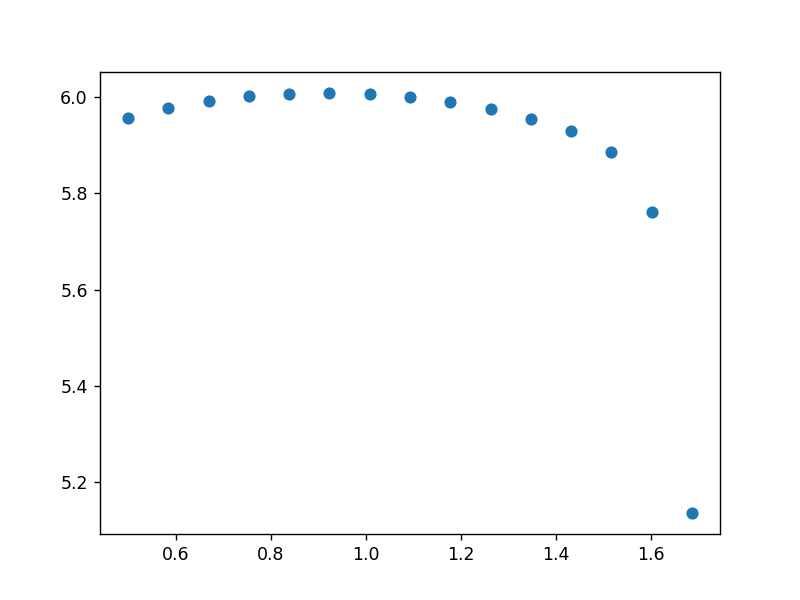

In [52]:
#5.2.6.1.3.1. Owner's Value Function (2d) - Second Source of Concavity (When staying is better) - Grid
plt.plot(hgrid,V_s[LT-2][0],'o')
ax.set_xlabel('House Value/Wealth')
ax.set_ylabel('Value')
plt.title('')
plt.show()

<IPython.core.display.Javascript object>


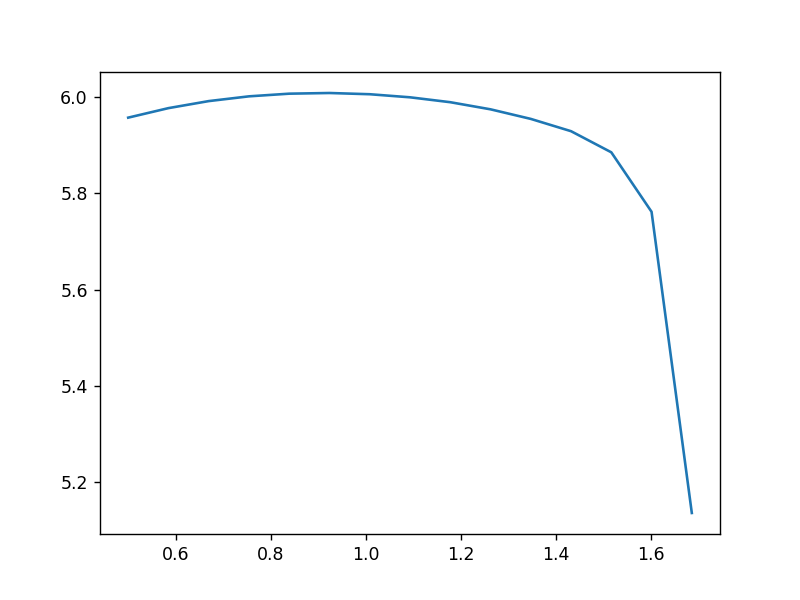

In [61]:
#5.2.6.1.3.2. Owner's Value Function (2d) - Second Source of Concavity (When staying is better) - Interpolation
V_s2 = interpolate.interp2d(hgrid, xgrid, V_s[LT-2], kind='linear', bounds_error=False)
plt.plot(hgrid, V_s2(hgrid,xgrid[0]))
ax.set_xlabel('House Value/Wealth')
ax.set_ylabel('Value')
plt.title('')
plt.show()

## 7. Saving the Solutions 

In [22]:
#7.0. cf) For calling the previous result - Optimal Policy and Value Functions

#os.chdir(r'C:\Users\Owner\Dropbox\8. Python Space\Research1-HousingPortfolioJeonseData\PreviousResultForCheck')
#V_r       = np.load('V_r.npy')     
#c_r       = np.load('c_r.npy')     
#h_r       = np.load('h_r.npy')     
#a_r       = np.load('a_r.npy')     
#alpha_r   = np.load('alpha_r.npy') 
#V_j       = np.load('V_j.npy')     
#c_j       = np.load('c_j.npy')     
#h_j       = np.load('h_j.npy')     
#a_j       = np.load('a_j.npy')     
#alpha_j   = np.load('alpha_j.npy') 
#V_p       = np.load('V_p.npy')     
#c_p       = np.load('c_p.npy')     
#h_p       = np.load('h_p.npy')     
#a_p       = np.load('a_p.npy')     
#alpha_p   = np.load('alpha_p.npy') 
#V_s       = np.load('V_s.npy')     
#c_s       = np.load('c_s.npy')     
#h_s       = np.load('h_s.npy')     
#a_s       = np.load('a_s.npy')     
#alpha_s   = np.load('alpha_s.npy') 
#V_ow      = np.load('V_ow.npy')    
#ht_ow     = np.load('ht_ow.npy')   
#V_nonow   = np.load('V_nonow.npy') 
#ht_nonow  = np.load('ht_nonow.npy')

In [43]:
#7.1. Saving the result array

#os.chdir(r'C:\Users\Owner\Dropbox\8. Python Space\Research1-HousingPortfolioJeonseData\PreviousResultForSaving')
np.save('V_r', V_r)
np.save('c_r', c_r)
np.save('h_r', h_r)
np.save('a_r', a_r)
np.save('alpha_r', alpha_r)
np.save('V_j', V_j)
np.save('c_j', c_j)
np.save('h_j', h_j)
np.save('a_j', a_j)
np.save('alpha_j', alpha_j)
np.save('V_p', V_p)
np.save('c_p', c_p)
np.save('h_p', h_p)
np.save('a_p', a_p)
np.save('alpha_p', alpha_p)
np.save('V_s', V_s)
np.save('c_s', c_s)
np.save('h_s', h_s)
np.save('a_s', a_s)
np.save('alpha_s', alpha_s)
np.save('V_ow', V_ow)
np.save('ht_ow', ht_ow)
np.save('V_nonow', V_nonow)
np.save('ht_nonow', ht_nonow)

#11.11. Paramter를 Save 같이해서 나중에 확인하기 쉽게 하자.. (Update 요망)

## 8. Presenting Results

In [19]:
#8.1. What is the Calibration for this Practice? - 11.11. 이 부분도 같이 Update
print(omega, ':housing versus non-durable consumption')
print(rho, ':inverse of the elasticity of intertemporal substitution')
print(gamma, ':CRRA risk aversion')
print(beta, ':discount factor')
print(xi, ':probability of moving') #- Vestman 2019 different for each age
print(alpha_f, ':bequest strength (annuity factor)')
print(beta_b, ':bequest strength (discount factor)')
print(T_b, ':bequest strength (time period)')
print(lambda_r, ':ratio of retirement income to the last working age income')
print(R_f, ':risk free rate')
print(mu_r, ':risk premium')
print(mu_h, ':expected growth of house price')
print(tau_r, ':ratio of yearly rent to house price')
print(Jbar, ':ratio of Jeonse deposit to house price -> Refer to the R.file')
print(delta_J, ':downpayment ratio for Jeonse')
print(phi_J, ':Jeonse contract cost')
print(chi, ':maintenance fee')
print(delta, ':downpayment ratio for home purchase')
print(phi_b, ':House purchase cost')
print(phi, ':selling cost')
print(Hbar, ':minimum house value (lower than it, rent or jeonse)')
print(delta_v, ':standard deviation of idiosyncratic labor income shock')
print(delta_ep, ':standard deviation of idiosyncratic stock market return')
print(delta_n, ':standard deviation of housing return')
print(corrHS, ':correlation between housing return and stock return correlation')
print(eta_en, ':coefficient in front of stock return shock so that it goes into housing return equation for correlation')
print(corrYS, ':correlation between labor income and stock return')
print(corrHY, ':correlation between housing return and labor income')
print(eta_nn, ':coefficient for shock correlated to housing return and exist in labor income shock part')
print(eta_eo, ':coefficient for shock correlated to stock return and exist in labor income shock part')
print(LT, ':Longevity 20 - 80')
print(b_b, ':bequest constant multiplier')
print(Lage, ':Retirement Age')
print(DTI_J, ':DTI constraint for Jeonse Renter')
print(DTI_H, ':DTI constraint for Homeowner')

0.33 :housing versus non-durable consumption
0.3333333333333333 :inverse of the elasticity of intertemporal substitution
4.0 :CRRA risk aversion
0.97 :discount factor
0.01 :probability of moving
0.35 :bequest strength (annuity factor)
0.91 :bequest strength (discount factor)
3.0 :bequest strength (time period)
0.65 :ratio of retirement income to the last working age income
1.03 :risk free rate
0.035 :risk premium
0.02 :expected growth of house price
0.036509 :ratio of yearly rent to house price
0.6638 :ratio of Jeonse deposit to house price -> Refer to the R.file
0.5 :downpayment ratio for Jeonse
0.015 :Jeonse contract cost
0.003 :maintenance fee
0.6 :downpayment ratio for home purchase
0.015 :House purchase cost
0.01 :selling cost
500.0 :minimum house value (lower than it, rent or jeonse)
0.1283 :standard deviation of idiosyncratic labor income shock
0.2 :standard deviation of idiosyncratic stock market return
0.2 :standard deviation of housing return
0.1 :correlation between housing 

## 8.1. Housing Tenure of Non-owner by Age and Wealth 

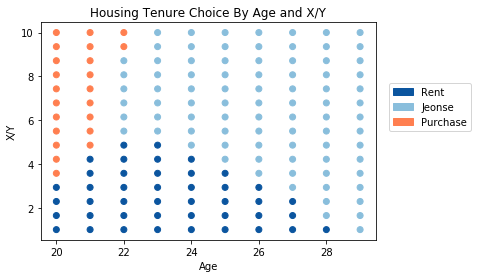

In [25]:
#7.1.1. Age Column
a=np.array([])
for i in range(0,LT):
    b=np.repeat([i],len(xgrid))
    a=np.concatenate((a,b))

a=a+20

#7.1.2. Wealth Column
c=np.array([])
for i in range(0,LT):
    c=np.concatenate((c,xgrid))

#Inverse (our state var is Y/X which means X/Y the inverse is more appropriate to represent the wealth)
d=c**(-1)

#7.1.3. Housing Tenure by age and wealth
e=np.array([])
for i in range(0,LT):
    e=np.concatenate((e,ht_nonow[i]))
    
#7.1.4. Make it as a dataframe
a=pd.DataFrame(a)
c=pd.DataFrame(c)
d=pd.DataFrame(d)
e=pd.DataFrame(e)

result1 = pd.concat([a, c, d, e], axis=1, sort=False)
result1.columns=['age','X/Y','Y/X','Tenure']

#7.1.5. Make it as a colored graph (color-tenure, yaxis-wealth, xaxis-age)
d=np.array(result1['Tenure'])
d=d.astype(int) #for later use

colormap = np.array(['#0b559f', '#89bedc','coral'])
plt.scatter(result1['age'], result1['X/Y'], c=colormap[d])

ht_a = mpatches.Patch(color='#0b559f', label='Rent') #0
ht_b = mpatches.Patch(color='#89bedc', label='Jeonse') #1
ht_c = mpatches.Patch(color='coral', label='Purchase') #2

plt.legend(handles=[ht_a,ht_b,ht_c], loc=(1.04,0.5))
plt.title('Housing Tenure Choice By Age and X/Y')
plt.ylabel('X/Y')
plt.xlabel('Age')
plt.show() #should have better grid...

#Possible tradeoff 
#- house (no adjustment cost - good to have a long-run)
#- jeonse (cheaper to finance (tau_r > R_f) but as home bigger the transaction cost increases - only wealthy worth it?), 

In [432]:
###############################################################################################################
################## 7.2. Housing Tenure of Owner by House value and Wealth for Specific Ages ###################
###############################################################################################################

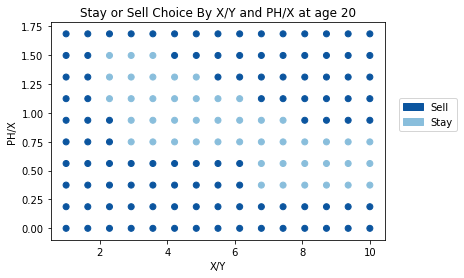

In [26]:
#7.2.1. Age 0, at 20 
age=0

#7.2.1.1. Labor Income Column
a=np.array([])
for i in range(0,len(xgrid)):
    b=np.repeat(xgrid[i],len(hgrid))
    a=np.concatenate((a,b))

#7.2.1.2. House Value Column
c=np.array([])
for i in range(0,len(xgrid)):
    c=np.concatenate((c,hgrid))

#Inverse (our state var is X/Y which means Y/X the inverse is more appropriate to represent the wealth)
d=a**(-1)

#7.2.1.3. Housing Tenure by age and wealth
e=np.array([])
for i in range(0,len(xgrid)):
    e=np.concatenate((e,ht_ow[age][i]))

#7.2.1.4. Make it as a dataframe
a=pd.DataFrame(a)
c=pd.DataFrame(c)
d=pd.DataFrame(d)
e=pd.DataFrame(e)

result1 = pd.concat([a, c, e], axis=1, sort=False)
result1.columns=['X/Y','PH/X','Tenure']

#7.2.1.5. Make it as a colored graph (color-tenure, yaxis-wealth, xaxis-age)
d=np.array(result1['Tenure'])
d=d.astype(int) #for later use

colormap = np.array(['#0b559f', '#89bedc'])
plt.scatter(result1['X/Y'], result1['PH/X'], c=colormap[d])

ht_a = mpatches.Patch(color='#0b559f', label='Sell') #0
ht_b = mpatches.Patch(color='#89bedc', label='Stay') #1

plt.legend(handles=[ht_a,ht_b], loc=(1.04,0.5))
plt.title('Stay or Sell Choice By X/Y and PH/X at age '+str(age+20))
plt.xlabel('X/Y')
plt.ylabel('PH/X')
plt.show() #should have better grid...

#Possible tradeoff 
#- house (no adjustment cost - good to have a long-run)
#- jeonse (cheaper to finance (tau_r > R_f) but as home bigger the transaction cost increases - only wealthy worth it?), 

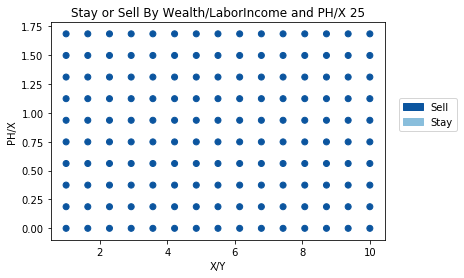

In [102]:
#7.2.2. Age a, at 20+a 
age=5

#7.2.2.1. Labor Income Column
a=np.array([])
for i in range(0,len(xgrid)):
    b=np.repeat(xgrid[i],len(hgrid))
    a=np.concatenate((a,b))

#7.2.2.2. House Value Column
c=np.array([])
for i in range(0,len(xgrid)):
    c=np.concatenate((c,hgrid))

#Inverse (our state var is X/Y which means Y/X the inverse is more appropriate to represent the wealth)
d=a**(-1)

#7.2.2.3. Housing Tenure by age and wealth
e=np.array([])
for i in range(0,len(xgrid)):
    e=np.concatenate((e,ht_ow[age][i]))

#7.2.2.4. Make it as a dataframe
a=pd.DataFrame(a)
c=pd.DataFrame(c)
d=pd.DataFrame(d)
e=pd.DataFrame(e)

result1 = pd.concat([a, c, e], axis=1, sort=False)
result1.columns=['X/Y','PH/X','Tenure']

#7.2.2.5. Make it as a colored graph (color-tenure, yaxis-wealth, xaxis-age)
d=np.array(result1['Tenure'])
d=d.astype(int) #for later use

colormap = np.array(['#0b559f', '#89bedc'])
plt.scatter(result1['X/Y'], result1['PH/X'], c=colormap[d])

ht_a = mpatches.Patch(color='#0b559f', label='Sell') #0
ht_b = mpatches.Patch(color='#89bedc', label='Stay') #1

plt.legend(handles=[ht_a,ht_b], loc=(1.04,0.5))
plt.xlabel('X/Y')
plt.ylabel('PH/X')
plt.title('Stay or Sell By Wealth/LaborIncome and PH/X '+str(age+20))
plt.show() #should have better grid...

#Possible tradeoff 
#- house (no adjustment cost - good to have a long-run)
#- jeonse (cheaper to finance (tau_r > R_f) but as home bigger the transaction cost increases - only wealthy worth it?), 

In [103]:
##################################################################################################
################## 7.3. Other Choices by House value and Wealth for Specific Ages ################
##################################################################################################

In [104]:
########################################################################################################################################
################## 7.3.1. Which type of owner do we want to check? - Policy Function Stayer with specific housing value ################
########################################################################################################################################

In [105]:
#7.3.1.1. What is the value 'h' that we wanna see for owner (stayer)?

#1) They have to choose to stay?
#2) little bit larger than optimal value 
#3) little bit lower than optimal value 


#7.3.1.2. Save the optimal policy functions for these HH

#Define a policy functions for the homeowner with highh and low h
#As housing value is fixed, their dimensions are like above.

#High House value
c_shigh      = np.zeros((LT+1, nx))
h_shigh      = np.zeros((LT+1, nx)) #Will be same with given h value
a_shigh      = np.zeros((LT+1, nx))
alpha_shigh  = np.zeros((LT+1, nx))
ht_owhigh    = numpy.zeros((LT, nx))

#Low House value
c_slow      = np.zeros((LT+1, nx))
h_slow      = np.zeros((LT+1, nx)) #Will be same with given h value
a_slow      = np.zeros((LT+1, nx))
alpha_slow  = np.zeros((LT+1, nx))
ht_owlow    = numpy.zeros((LT, nx))
# save the optimal policies into the array! 
# later plot it - label name depends on hhigh value,...

for i in range(0,LT):
    hmax0=max(h_p[i]) #maximum among optimal choice with different y/x for 2)
    hmin0=min(h_p[i]) #minimum among optimal choice with different y/x for 3)
    
    #Find points closest to these values
    A=hgrid>hmax0
    B=hgrid<hmin0
    #print(A)
    #print(B)
    
    #Points that are closest to the values in which we are interested
    itemindex1 = np.where(A==True)
    itemindex1 = min(itemindex1[0])
    itemindex2 = np.where(B==False)
    itemindex2 = min(itemindex2[0])
    itemindex2 = itemindex2
    
    #point in hgrid that contains the h value that I wanna see
    highh=hgrid[itemindex1]
    lowh=hgrid[itemindex2]
    #print(highh)
    #print(lowh)
    for j in range(0,len(xgrid)):
        #With high h value - house bigger than optimal size
        c_shigh[i,j]=c_s[i,j,itemindex1]
        h_shigh[i,j]=h_s[i,j,itemindex1] #check whether it is same with hgrid[itemindex1] value
        a_shigh[i,j]=a_s[i,j,itemindex1]
        alpha_shigh[i,j]=alpha_s[i,j,itemindex1]
        ht_owhigh[i,j]=ht_ow[i,j,itemindex1]
        #With low h value - house smaller than optimal size        
        c_slow[i,j]=c_s[i,j,itemindex2]
        h_slow[i,j]=h_s[i,j,itemindex2]
        a_slow[i,j]=a_s[i,j,itemindex2]
        alpha_slow[i,j]=alpha_s[i,j,itemindex2]
        ht_owlow[i,j]=ht_ow[i,j,itemindex2]

In [106]:
######################################################################
################## 7.3.2. Make a Dataframe for graphs ################
######################################################################

In [107]:
#7.3.1.1. Consumption and Housing Consumption, Housing Quality by Wealth and Housing Tenure

for age in range(0,LT):
    x=xgrid
    y=x**(-1)
    #y=np.concatenate((y,y))
    c1=c_r[age]
    h10=h_r[age]
    h11=h_r[age]*tau_r
    c2=c_j[age]
    h20=h_j[age]
    h21=h_j[age]*(delta_J+phi_J)*Jbar
    c3=c_p[age]
    h30=h_p[age]
    h31=h_p[age]*(chi+delta+phi_b)
    c4=c_shigh[age]
    h40=h_shigh[age]
    h41=h_shigh[age]*(chi+delta-phi)
    c5=c_slow[age]
    h50=h_slow[age]
    h51=h_slow[age]*(chi+delta-phi)    
    #a=np.concatenate((a1,a2))
    #alpha=np.concatenate((alpha1,alpha2))
    b=np.repeat(0,len(xgrid))
    c=np.repeat(1,len(xgrid))
    z=np.repeat(2,len(xgrid))
    z1=ht_owhigh[age]
    z2=ht_owlow[age]
    #d=np.concatenate((b,c))
    y=pd.DataFrame(y)
    x=pd.DataFrame(x)
    c1=pd.DataFrame(c1)
    c2=pd.DataFrame(c2)
    c3=pd.DataFrame(c3)
    c4=pd.DataFrame(c4)
    c5=pd.DataFrame(c5)
    h10=pd.DataFrame(h10)
    h20=pd.DataFrame(h20)
    h30=pd.DataFrame(h30)
    h40=pd.DataFrame(h40)
    h50=pd.DataFrame(h50)
    h11=pd.DataFrame(h11)
    h21=pd.DataFrame(h21)
    h31=pd.DataFrame(h31)
    h41=pd.DataFrame(h41)
    h51=pd.DataFrame(h51)
    b=pd.DataFrame(b)
    c=pd.DataFrame(c)
    z=pd.DataFrame(z)
    z1=pd.DataFrame(z1)
    z2=pd.DataFrame(z2)
    name1='chresult_r_'+str(age)
    name2='chresult_j_'+str(age)
    name3='chresult_p_'+str(age)
    name4='chresult_shigh_'+str(age) #stayer with high home value
    name5='chresult_slow_'+str(age) #stayer with low home value
    vars()[name1] = pd.concat([y, x, c1, h10, h11, b], axis=1, sort=False)
    vars()[name1].columns=['Y/X','X/Y','Consumption Ratio','Housing', 'HousingExpenditure', 'HousingTenure']
    vars()[name2] = pd.concat([y, x, c2, h20, h21, c], axis=1, sort=False)
    vars()[name2].columns=['Y/X','X/Y','Consumption Ratio','Housing', 'HousingExpenditure', 'HousingTenure']
    vars()[name3] = pd.concat([y, x, c3, h30, h31, z], axis=1, sort=False)
    vars()[name3].columns=['Y/X','X/Y','Consumption Ratio','Housing', 'HousingExpenditure', 'HousingTenure']
    vars()[name4] = pd.concat([y, x, c4, h40, h41, z1], axis=1, sort=False)
    vars()[name4].columns=['Y/X','X/Y','Consumption Ratio','Housing', 'HousingExpenditure', 'HousingTenure']
    vars()[name5] = pd.concat([y, x, c5, h50, h51, z2], axis=1, sort=False)
    vars()[name5].columns=['Y/X','X/Y','Consumption Ratio','Housing', 'HousingExpenditure', 'HousingTenure']

In [108]:
#7.3.1.2. Saving and Portfolio Choice by Wealth and Housing Tenure

for age in range(0,LT):
    x=xgrid
    #y=np.concatenate((y,y))
    y=x**(-1)
    a1=a_r[age]
    alpha1=alpha_r[age]
    a2=a_j[age]
    alpha2=alpha_j[age]
    a3=a_p[age]
    alpha3=alpha_p[age]
    a4=a_shigh[age]
    alpha4=alpha_shigh[age]
    a5=a_slow[age]
    alpha5=alpha_slow[age]
    #a=np.concatenate((a1,a2))
    #alpha=np.concatenate((alpha1,alpha2))
    b=np.repeat(0,len(xgrid))
    c=np.repeat(1,len(xgrid))
    z=np.repeat(2,len(xgrid))
    z1=ht_owhigh[age]
    z2=ht_owlow[age]
    #d=np.concatenate((b,c))
    y=pd.DataFrame(y)
    x=pd.DataFrame(x)
    a1=pd.DataFrame(a1)
    a2=pd.DataFrame(a2)
    a3=pd.DataFrame(a3)
    a4=pd.DataFrame(a4)
    a5=pd.DataFrame(a5)
    alpha1=pd.DataFrame(alpha1)
    alpha2=pd.DataFrame(alpha2)
    alpha3=pd.DataFrame(alpha3)
    alpha4=pd.DataFrame(alpha4)
    alpha5=pd.DataFrame(alpha5)
    b=pd.DataFrame(b)
    c=pd.DataFrame(c)
    z=pd.DataFrame(z)
    z1=pd.DataFrame(z1)
    z2=pd.DataFrame(z2)
    name1='result_r_'+str(age)
    name2='result_j_'+str(age)
    name3='result_p_'+str(age)
    name4='result_shigh_'+str(age) #stayer with high home value
    name5='result_slow_'+str(age) #stayer with low home value
    vars()[name1] = pd.concat([y, x, a1, alpha1, b], axis=1, sort=False)
    vars()[name1].columns=['Y/X','X/Y','Saving Ratio','RiskyAssetRatio','HousingTenure']
    vars()[name2] = pd.concat([y, x, a2, alpha2, c], axis=1, sort=False)
    vars()[name2].columns=['Y/X','X/Y','Saving Ratio','RiskyAssetRatio','HousingTenure']
    vars()[name3] = pd.concat([y, x, a3, alpha3, z], axis=1, sort=False)
    vars()[name3].columns=['Y/X','X/Y','Saving Ratio','RiskyAssetRatio','HousingTenure']
    vars()[name4] = pd.concat([y, x, a4, alpha4, z1], axis=1, sort=False)
    vars()[name4].columns=['Y/X','X/Y','Saving Ratio','RiskyAssetRatio','HousingTenure']
    vars()[name5] = pd.concat([y, x, a5, alpha5, z2], axis=1, sort=False)
    vars()[name5].columns=['Y/X','X/Y','Saving Ratio','RiskyAssetRatio','HousingTenure']

In [109]:
#################################################
################## 7.3.2. Age 20 ################ #https://matplotlib.org/3.1.0/gallery/color/named_colors.html - color
#################################################

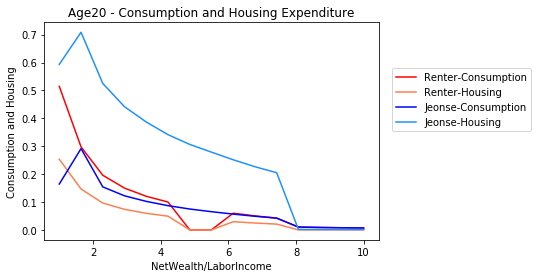

In [110]:
#7.3.2.1. Age-20-Choice - Consumption, Housing Expenditure

plt.plot(chresult_r_0['X/Y'], chresult_r_0['Consumption Ratio'], color='red', label='Renter-Consumption')
plt.plot(chresult_r_0['X/Y'], chresult_r_0['HousingExpenditure'], color='coral', label='Renter-Housing')
plt.plot(chresult_j_0['X/Y'], chresult_j_0['Consumption Ratio'], color='blue', label='Jeonse-Consumption')
plt.plot(chresult_j_0['X/Y'], chresult_j_0['HousingExpenditure'], color='dodgerblue', label='Jeonse-Housing')


plt.ylabel('Consumption and Housing')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age20 - Consumption and Housing Expenditure')
plt.legend(loc=(1.04,0.5))
plt.show()

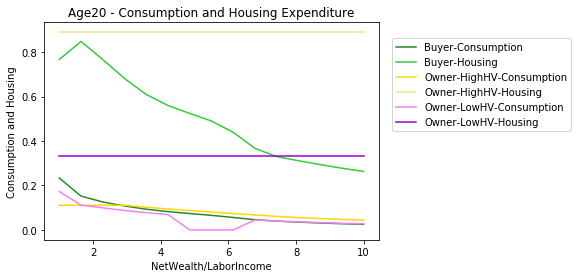

In [111]:
#7.3.2.1. Age-20-Choice - Consumption, Housing Expenditure

plt.plot(chresult_p_0['X/Y'], chresult_p_0['Consumption Ratio'], color='forestgreen', label='Buyer-Consumption')
plt.plot(chresult_p_0['X/Y'], chresult_p_0['HousingExpenditure'], color='limegreen', label='Buyer-Housing')
plt.plot(chresult_shigh_0['X/Y'], chresult_shigh_0['Consumption Ratio'], color='Gold', label='Owner-HighHV-Consumption')
plt.plot(chresult_shigh_0['X/Y'], chresult_shigh_0['HousingExpenditure'], color='Khaki', label='Owner-HighHV-Housing')
plt.plot(chresult_slow_0['X/Y'], chresult_slow_0['Consumption Ratio'], color='Violet', label='Owner-LowHV-Consumption')
plt.plot(chresult_slow_0['X/Y'], chresult_slow_0['HousingExpenditure'], color='DarkViolet', label='Owner-LowHV-Housing')

plt.ylabel('Consumption and Housing')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age20 - Consumption and Housing Expenditure')
plt.legend(loc=(1.04,0.5))
plt.show()

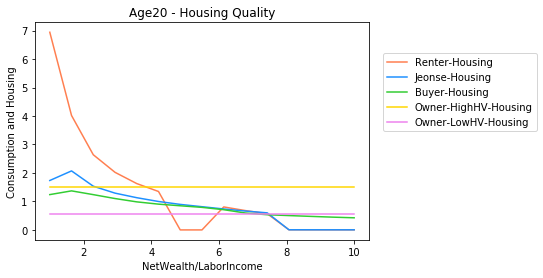

In [112]:
#7.3.2.2. Age-20-Choice - Housing Qualtiy

plt.plot(chresult_r_0['X/Y'], chresult_r_0['Housing'], color='coral', label='Renter-Housing')
plt.plot(chresult_j_0['X/Y'], chresult_j_0['Housing'], color='dodgerblue', label='Jeonse-Housing')
plt.plot(chresult_p_0['X/Y'], chresult_p_0['Housing'], color='limegreen', label='Buyer-Housing')
plt.plot(chresult_shigh_0['X/Y'], chresult_shigh_0['Housing'], color='Gold', label='Owner-HighHV-Housing')
plt.plot(chresult_slow_0['X/Y'], chresult_slow_0['Housing'], color='Violet', label='Owner-LowHV-Housing')

plt.ylabel('Consumption and Housing')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age20 - Housing Quality')
plt.legend(loc=(1.04, 0.5))
plt.show()

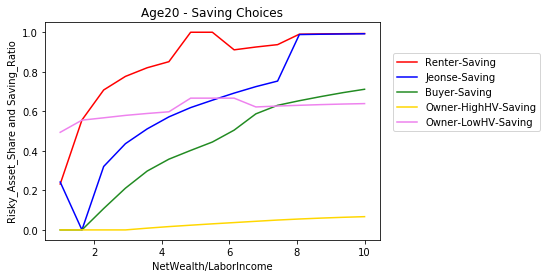

In [113]:
#7.3.2.3. Age-20-Choice - Saving Choices

plt.plot(result_r_0['X/Y'], result_r_0['Saving Ratio'], color='red', label='Renter-Saving')
plt.plot(result_j_0['X/Y'], result_j_0['Saving Ratio'], color='blue', label='Jeonse-Saving')
plt.plot(result_p_0['X/Y'], result_p_0['Saving Ratio'], color='forestgreen', label='Buyer-Saving')
plt.plot(result_shigh_0['X/Y'], result_shigh_0['Saving Ratio'], color='Gold', label='Owner-HighHV-Saving')
plt.plot(result_slow_0['X/Y'], result_slow_0['Saving Ratio'], color='Violet', label='Owner-LowHV-Saving')

plt.ylabel('Risky_Asset_Share and Saving_Ratio')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age20 - Saving Choices')
plt.legend(loc=(1.04,0.5))
plt.show()

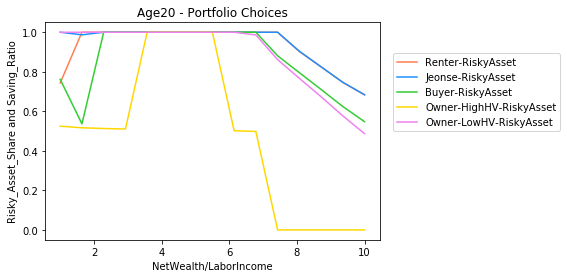

In [114]:
#7.3.2.4. Age-20-Choice - Portfolio Choices

plt.plot(result_r_0['X/Y'], result_r_0['RiskyAssetRatio'], color='coral', label='Renter-RiskyAsset')
plt.plot(result_j_0['X/Y'], result_j_0['RiskyAssetRatio'], color='dodgerblue', label='Jeonse-RiskyAsset')
plt.plot(result_p_0['X/Y'], result_p_0['RiskyAssetRatio'], color='limegreen', label='Buyer-RiskyAsset')
plt.plot(result_shigh_0['X/Y'], result_shigh_0['RiskyAssetRatio'], color='Gold', label='Owner-HighHV-RiskyAsset')
plt.plot(result_slow_0['X/Y'], result_slow_0['RiskyAssetRatio'], color='Violet', label='Owner-LowHV-RiskyAsset')

plt.ylabel('Risky_Asset_Share and Saving_Ratio')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age20 - Portfolio Choices')
plt.legend(loc=(1.04,0.5))
plt.show()

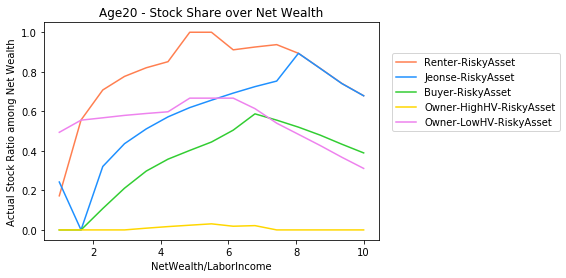

In [115]:
#7.3.2.5. Age-20-Choice - Actual Stock Holding

plt.plot(result_r_0['X/Y'], result_r_0['RiskyAssetRatio']*result_r_0['Saving Ratio'], color='coral', label='Renter-RiskyAsset')
plt.plot(result_j_0['X/Y'], result_j_0['RiskyAssetRatio']*result_j_0['Saving Ratio'], color='dodgerblue', label='Jeonse-RiskyAsset')
plt.plot(result_p_0['X/Y'], result_p_0['RiskyAssetRatio']*result_p_0['Saving Ratio'], color='limegreen', label='Buyer-RiskyAsset')
plt.plot(result_shigh_0['X/Y'], result_shigh_0['RiskyAssetRatio']*result_shigh_0['Saving Ratio'], color='Gold', label='Owner-HighHV-RiskyAsset')
plt.plot(result_slow_0['X/Y'], result_slow_0['RiskyAssetRatio']*result_slow_0['Saving Ratio'], color='Violet', label='Owner-LowHV-RiskyAsset')

plt.ylabel('Actual Stock Ratio among Net Wealth')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age20 - Stock Share over Net Wealth')
plt.legend(loc=(1.04,0.5))
plt.show()

In [116]:
#######################################################
################## 7.3.3. Age '20+age' ################
#######################################################

In [117]:
age=5

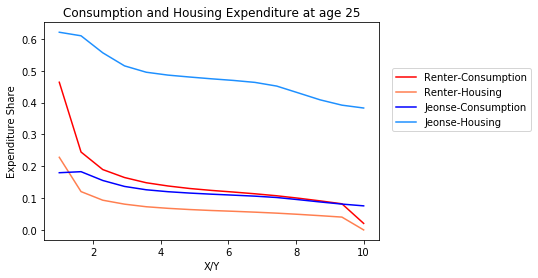

In [118]:
#7.3.3.1. Age-'20+age'-Choice - Consumption and Housing Expenditure - Renter - Jeonse

namer1='chresult_r_'+str(age)
namej1='chresult_j_'+str(age)
namep1='chresult_p_'+str(age)
namesh1='chresult_shigh_'+str(age)
namesl1='chresult_slow_'+str(age)

plt.plot(vars()[namer1]['X/Y'], vars()[namer1]['Consumption Ratio'], color='red', label='Renter-Consumption')
plt.plot(vars()[namer1]['X/Y'], vars()[namer1]['HousingExpenditure'], color='coral', label='Renter-Housing')
plt.plot(vars()[namej1]['X/Y'], vars()[namej1]['Consumption Ratio'], color='blue', label='Jeonse-Consumption')
plt.plot(vars()[namej1]['X/Y'], vars()[namej1]['HousingExpenditure'], color='dodgerblue', label='Jeonse-Housing')

plt.ylabel('Expenditure Share')
plt.xlabel('X/Y')
plt.title('Consumption and Housing Expenditure at age '+str(age+20))
plt.legend(loc=(1.04,0.5))
plt.show()

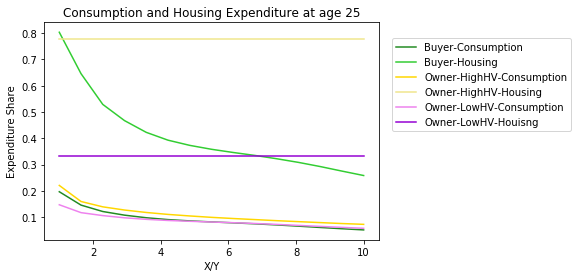

In [119]:
#7.3.3.1. Age-'20+age'-Choice - Consumption and Housing Expenditure - Buyer and Owner

plt.plot(vars()[namep1]['X/Y'], vars()[namep1]['Consumption Ratio'], color='forestgreen', label='Buyer-Consumption')
plt.plot(vars()[namep1]['X/Y'], vars()[namep1]['HousingExpenditure'], color='limegreen', label='Buyer-Housing')
plt.plot(vars()[namesh1]['X/Y'], vars()[namesh1]['Consumption Ratio'], color='Gold', label='Owner-HighHV-Consumption')
plt.plot(vars()[namesh1]['X/Y'], vars()[namesh1]['HousingExpenditure'], color='Khaki', label='Owner-HighHV-Housing')
plt.plot(vars()[namesl1]['X/Y'], vars()[namesl1]['Consumption Ratio'], color='Violet', label='Owner-LowHV-Consumption')
plt.plot(vars()[namesl1]['X/Y'], vars()[namesl1]['HousingExpenditure'], color='DarkViolet', label='Owner-LowHV-Houisng')

plt.ylabel('Expenditure Share')
plt.xlabel('X/Y')
plt.title('Consumption and Housing Expenditure at age '+str(age+20))
plt.legend(loc=(1.04,0.5))
plt.show()

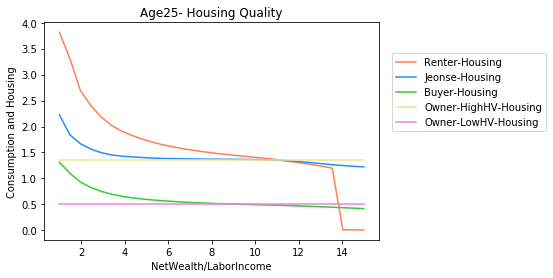

In [456]:
#7.3.3.2. Age-'20+age'-Choice - Housing Quality

plt.plot(vars()[namer1]['X/Y'], vars()[namer1]['Housing'], color='coral', label='Renter-Housing')
plt.plot(vars()[namej1]['X/Y'], vars()[namej1]['Housing'], color='dodgerblue', label='Jeonse-Housing')
plt.plot(vars()[namep1]['X/Y'], vars()[namep1]['Housing'], color='limegreen', label='Buyer-Housing')
plt.plot(vars()[namesh1]['X/Y'], vars()[namesh1]['Housing'], color='Khaki', label='Owner-HighHV-Housing')
plt.plot(vars()[namesl1]['X/Y'], vars()[namesl1]['Housing'], color='Violet', label='Owner-LowHV-Housing')

plt.ylabel('Consumption and Housing')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age'+str(age+20)+'- Housing Quality')
plt.legend(loc=(1.04,0.5))
plt.show()

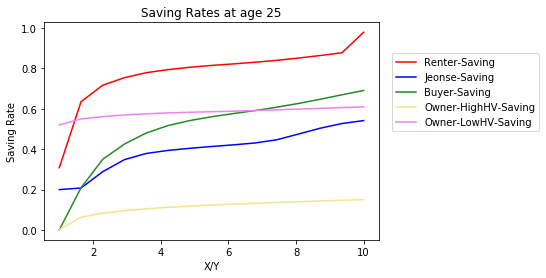

In [122]:
#7.3.3.3. Age-'20+age'-Choice - Saving Choice

namer2='result_r_'+str(age)
namej2='result_j_'+str(age)
namep2='result_p_'+str(age)
namesh1='result_shigh_'+str(age)
namesl1='result_slow_'+str(age)

plt.plot(vars()[namer2]['X/Y'], vars()[namer2]['Saving Ratio'], color='red', label='Renter-Saving')
plt.plot(vars()[namej2]['X/Y'], vars()[namej2]['Saving Ratio'], color='blue', label='Jeonse-Saving')
plt.plot(vars()[namep2]['X/Y'], vars()[namep2]['Saving Ratio'], color='forestgreen', label='Buyer-Saving')
plt.plot(vars()[namesh1]['X/Y'], vars()[namesh1]['Saving Ratio'], color='Khaki', label='Owner-HighHV-Saving')
plt.plot(vars()[namesl1]['X/Y'], vars()[namesl1]['Saving Ratio'], color='Violet', label='Owner-LowHV-Saving')

plt.ylabel('Saving Rate')
plt.xlabel('X/Y')
plt.title('Saving Rates at age '+str(age+20))
plt.legend(loc=(1.04,0.5))
plt.show()

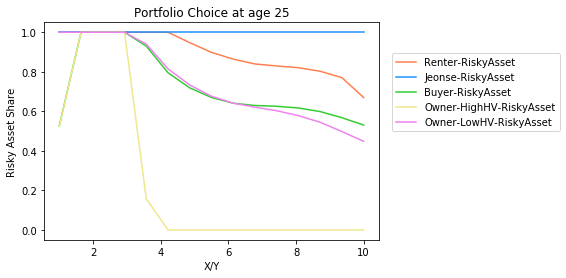

In [123]:
#7.3.3.4. Age-'20+age'-Choice - Portfolio Choice

plt.plot(vars()[namer2]['X/Y'], vars()[namer2]['RiskyAssetRatio'], color='coral', label='Renter-RiskyAsset')
plt.plot(vars()[namej2]['X/Y'], vars()[namej2]['RiskyAssetRatio'], color='dodgerblue', label='Jeonse-RiskyAsset')
plt.plot(vars()[namep2]['X/Y'], vars()[namep2]['RiskyAssetRatio'], color='limegreen', label='Buyer-RiskyAsset')
plt.plot(vars()[namesh1]['X/Y'], vars()[namesh1]['RiskyAssetRatio'], color='Khaki', label='Owner-HighHV-RiskyAsset')
plt.plot(vars()[namesl1]['X/Y'], vars()[namesl1]['RiskyAssetRatio'], color='Violet', label='Owner-LowHV-RiskyAsset')


plt.ylabel('Risky Asset Share')
plt.xlabel('X/Y')
plt.title('Portfolio Choice at age '+str(age+20))
plt.legend(loc=(1.04,0.5))
plt.show()

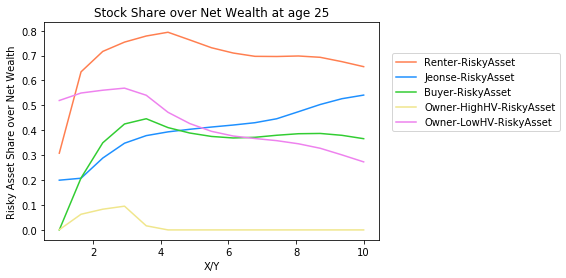

In [125]:
#7.3.3.4. Age-'20+age'-Choice - Actual Stock Holding

plt.plot(vars()[namer2]['X/Y'], vars()[namer2]['RiskyAssetRatio']*vars()[namer2]['Saving Ratio'], color='coral', label='Renter-RiskyAsset')
plt.plot(vars()[namej2]['X/Y'], vars()[namej2]['RiskyAssetRatio']*vars()[namej2]['Saving Ratio'], color='dodgerblue', label='Jeonse-RiskyAsset')
plt.plot(vars()[namep2]['X/Y'], vars()[namep2]['RiskyAssetRatio']*vars()[namep2]['Saving Ratio'], color='limegreen', label='Buyer-RiskyAsset')
plt.plot(vars()[namesh1]['X/Y'], vars()[namesh1]['RiskyAssetRatio']*vars()[namesh1]['Saving Ratio'], color='Khaki', label='Owner-HighHV-RiskyAsset')
plt.plot(vars()[namesl1]['X/Y'], vars()[namesl1]['RiskyAssetRatio']*vars()[namesl1]['Saving Ratio'], color='Violet', label='Owner-LowHV-RiskyAsset')

plt.ylabel('Risky Asset Share over Net Wealth')
plt.xlabel('X/Y')
plt.title('Stock Share over Net Wealth at age '+str(age+20))
plt.legend(loc=(1.04,0.5))
plt.show()